# Overview
This notebook is to develop Twitter Sentiment Analysis Project

__Date__:  
2021-12-20

# Main Goal:

The Initial Goals with be more focusing on gaining software engineering skill
1) Understand API (serve and call)
2) Understand AWS ecosystem (services like EC2, Comprehend, S3 and concecpt about IAM role, user and policy)
3) Make an data webapp
4) Workflow for ML Model Serving
5) Configuration to work with remote server
6) Implement docker component
7) Implement CICD pipeline (start with github action)

Future Goal with be more on make real use of Twitter data and sentiment to make analysis either on crypto/stock market or help with doing business market research

What Has Been Done:
1. Understand available twitterAPI
2. Having a python function to get recent tweets
3. Having a python function to call AWS comprehend to get text sentiment
4. Having a fastapi backend and streamlit frontend and works with each other
5. Hosting the project on AWS EC2
6. Configured working environment on VSCode and Cloud9 to work with remote server

Project Pending:
1) make a more comprehensive visualization (more tweets shown and show analysis of sentiment)
2) add docker component
3) add CICD pipeline
4) enhance feature (include keyword searching)
5) create database (stream too maybe)
6) change external connection into more readable URL

In [131]:
import pandas as pd
import requests
import os
import json
import tweepy
from configparser import ConfigParser
import boto3

parser = ConfigParser()
parser.read('api_auth.cfg')

#This is the super secret information that will allow access to the Twitter API and AWS Comprehend
bearer_token = parser.get('api_tracker', 'bearer_token')
aws_key_id =  parser.get('api_tracker', 'aws_key_id')
aws_key =  parser.get('api_tracker', 'aws_key')

In [134]:
def search_recent_tweets_as_df(query, tweet_fields):
    client = tweepy.Client(bearer_token=bearer_token)
    tweets = client.search_recent_tweets(query=query, tweet_fields=tweet_fields, max_results=100)
    df=pd.DataFrame(tweets.data)
    
    return df

In [146]:
def text_sentiment(df):

    client = boto3.client('comprehend',  region_name='us-west-2')

    sentiment_list = []
    sentiment_score_positive_list = []
    sentiment_score_negative_list = []
    sentiment_score_neutral_list = []
    sentiment_score_mixed_list = []

    for text in df.text:
        #text_data = base64.b64decode(text).decode('utf-8').strip()
        sentiment_all = client.detect_sentiment(Text=text, LanguageCode='en')
        sentiment_list.append(sentiment_all['Sentiment'])
        sentiment_score_positive_list.append(sentiment_all['SentimentScore']['Positive'])
        sentiment_score_negative_list.append(sentiment_all['SentimentScore']['Negative'])
        sentiment_score_neutral_list.append(sentiment_all['SentimentScore']['Neutral'])
        sentiment_score_mixed_list.append(sentiment_all['SentimentScore']['Mixed'])

    df['sentiment'] = sentiment_list
    df['sentiment_score_positive'] = sentiment_score_positive_list
    df['sentiment_score_negative'] = sentiment_score_negative_list
    df['sentiment_score_mixed'] = sentiment_score_mixed_list

    return df

In [ ]:
query = 'from:Bitcoin -is:retweet' #get reply, 'conversation_id:1471510774505893906'
tweet_fields = ['context_annotations', 'created_at','conversation_id']

df = search_recent_tweets_as_df(query, tweet_fields)
df_sentiment = text_sentiment(df)
df_sentiment.to_csv('tweets_with_sentiment.csv')

print(df_sentiment.head())

## Output Visualization

In [140]:
df_sentiment = pd.read_csv('tweets_with_sentiment.csv')
df_sentiment

,context_annotations,conversation_id,created_at,id,text,sentiment,sentiment_score_positive,sentiment_score_negative,sentiment_score_mixed
0,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1473692922323386380,2021-12-22 16:32:27+00:00,1473692922323386380,Only you #Bitcoin buyers can prevent red candl...,NEUTRAL,0.039692,0.047798,0.006594
1,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1473691438424723463,2021-12-22 16:26:33+00:00,1473691438424723463,“It might make sense just to get some in case ...,NEUTRAL,0.080573,0.236311,0.000940
2,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1473419222562660355,2021-12-21 22:24:52+00:00,1473419222562660355,Financial companies &amp; central banks have w...,NEGATIVE,0.003547,0.534025,0.038486
3,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1473414095567130626,2021-12-21 22:04:29+00:00,1473414095567130626,Is this what $98k Nov and $135k Dec #Bitcoin l...,NEUTRAL,0.006312,0.016177,0.000051
4,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1473063792493809673,2021-12-20 22:52:30+00:00,1473063792493809673,There are around 4m #Bitcoin hodled at prices ...,NEUTRAL,0.021628,0.048044,0.029903
5,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1472941455756857344,2021-12-20 14:46:23+00:00,1472941455756857344,No one uses #Bitcoin... https://t.co/gEf2j0x3Co,NEUTRAL,0.005693,0.418330,0.032112
6,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1472941382499115012,2021-12-20 14:46:06+00:00,1472941382499115012,https://t.co/v0bw5t2heO,NEUTRAL,0.008507,0.002727,0.014681
7,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1472798967624716288,2021-12-20 05:20:11+00:00,1472798967624716288,https://t.co/zEeXbriMRQ,NEUTRAL,0.001258,0.000865,0.000325
8,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1472277258157002752,2021-12-18 18:47:06+00:00,1472277258157002752,🌊 https://t.co/WJpTWCJs3z,NEUTRAL,0.002698,0.000333,0.000157
9,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1471986419555917824,2021-12-17 23:31:25+00:00,1471986419555917824,The December 31st #Bitcoin options expiration ...,NEUTRAL,0.028714,0.353425,0.000248


In [142]:
df_sentiment.describe()

,conversation_id,id,sentiment_score_positive,sentiment_score_negative,sentiment_score_mixed
count,1.500000e+01,1.500000e+01,15.000000,15.000000,15.000000
mean,1.472551e+18,1.472562e+18,0.057666,0.113172,0.008296
std,8.286162e+14,8.174591e+14,0.122221,0.180189,0.013718
min,1.471511e+18,1.471511e+18,0.000437,0.000134,0.000007
25%,1.471704e+18,1.471786e+18,0.003122,0.002012,0.000159
50%,1.472799e+18,1.472799e+18,0.007467,0.016177,0.000325
75%,1.473239e+18,1.473239e+18,0.034203,0.142178,0.010638
max,1.473693e+18,1.473693e+18,0.458317,0.534025,0.038486


In [157]:
df_sentiment['sentiment'].value_counts()

NEUTRAL     14
NEGATIVE     1
Name: sentiment, dtype: int64

## Pending

## Related Guide

### 1)Hosting the project with EC2 Instance  
https://towardsdatascience.com/how-to-deploy-a-streamlit-app-using-an-amazon-free-ec2-instance-416a41f69dc3  
a)follow the guide to create instance  
b)command to ssh into ec2 instance
  ```
  chmod 400 ec2_twitter_project.pem
  ssh -i "ec2_twitter_project.pem" ubuntu@ec2-54-149-76-59.us-west-2.compute.amazonaws.com
  ```
c)install miniconda and add path  
```
sudo apt-get update
wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda.sh
bash ~/miniconda.sh -b -p ~/miniconda
echo "PATH=$PATH:$HOME/miniconda/bin" >> ~/.bashrc (asked by the article)
echo "PATH=$HOME/miniconda/bin:$PATH" >> ~/.bashrc (should use this instead, then the default python path will be looking into miniconda first)
source ~/.bashrc
```

### 2)Configure remote access from vscode  
a)move pem file to .ssh to allow remote access from vsc
```
mv /Users/xtan/Downloads/ec2_twitter_project.pem /Users/xtan/.ssh
```
b)then add the following code to /Users/xtan/.ssh/config  
```
Host aws_ec2_twitter
  HostName ec2-34-211-38-241.us-west-2.compute.amazonaws.com
  User ubuntu
  IdentityFile ~/.ssh/ec2_twitter_project.pem
```

### 3)Configure conda env inside remote server     
```
conda env create -f environment.yml
conda init bash then refresh terminal
conda activate tweetenv
pip install -r requirements.txt  (not sure why conda env create -f environment.yml cant help to install packages)
```

### 4)Configure EC2 Instance IAMRole to use AWS Comprehend   
a)add iamrole for that instance inorder to use aws comprehend  
b)the iamrole should have the right policy  
https://docs.aws.amazon.com/comprehend/latest/dg/access-control-managing-permissions.html#:~:text=ComprehendFullAccess%20%E2%80%93%20Grants%20full,StartSentimentDetectionJob%2C%20and%20StartTopicsDetectionJob


### 5)Connecting EC2 with cloud9(Similar to VSCode, it's an IDE for developemnt on AWS)  
https://towardsdatascience.com/creating-aws-ec2-and-connecting-it-with-aws-cloud9-ide-and-aws-s3-a6313aa82ec#5011  
a)create environment (best to have same region as the EC2 instance)  
b)then in the configuration, select -create and run in remote server(SSH connection)  
c)user as <ubuntu> (not sure why must be this), Host as EC2 Instance <Public IPv4 DNS>  
d)copy the public ssh key and use run this command inside the server  
e)echo <Paste the Copied Key> >> ~/.ssh/authorized_keys (can ssh from local server first)  
f)then create environment  
g)install nodejs as cloud9 need it  
```
sudo apt-get install -y nodejs
```
h)then copy the c9-install link   
https://dhj20r2nmszcd.cloudfront.net/static/c9-install.sh  
i)run this code inside ssh  
```
wget https://dhj20r2nmszcd.cloudfront.net/static/c9-install.sh
chmod a+x c9-install.sh
sudo apt-get -y install python
sudo apt-get install build-essential
./c9-install.sh
```
j)then can install the cloud9 already  

## Doubt:
1) os
2) why videos one cant work, github one can (request.get)
3) what is response returning (use dir(response) to list them out) / check this link https://www.geeksforgeeks.org/response-methods-python-requests/
4) vsc terminal which python is different path
5) @decorator, classess
6) why http://backend cant word
7) what does :8080 means
8) host vs port
9) iam role vs aim user
10) ec2 tcp, vs streamlit pot vs 8080
11) port forwarding to acess server port with local browser
12) python env, python3 .py, python.py, conda .py
13) AWS Iamrole, Policies, IAM users, how to check permissions
14) -Pip vs pip3

## Useful Notes
1. Github:  
https://github.com/twitterdev/Twitter-API-v2-sample-code  
2. API command:  
curl --request GET 'https://api.twitter.com/2/tweets/search/recent?query=from:twitterdev' --header 'Authorization: Bearer $BEARER_TOKEN'
3. Beginner Guide:  
beginner guide https://www.dataquest.io/blog/python-api-tutorial/
4. Get Requests Params:  
-url: enpoint that you want to request  
-auth: authentication if it is needed  
-params: queryparams (still trying to find out)  
5. Tweepy Sample Code:  
https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9
6. Kill fast api
https://stackoverflow.com/questions/64588486/address-already-in-use-fastapi
7. Permission to use AWS Comprehend with EC2 instance
-create an IAM role for that instance, and add comprehend policies to the role 
8. Connecting EC2 with Cloud9 IDE
https://towardsdatascience.com/creating-aws-ec2-and-connecting-it-with-aws-cloud9-ide-and-aws-s3-a6313aa82ec#eedd
9. SSH to remote server with VSC
https://www.youtube.com/watch?v=7kum46SFIaY
10. connecting streamlit (frontend) with backend
https://testdriven.io/blog/fastapi-streamlit/
11. hosting webapp on aws EC2
https://towardsdatascience.com/how-to-deploy-a-streamlit-app-using-an-amazon-free-ec2-instance-416a41f69dc3
12. data pipeline (with data streaming)
https://github.com/GhayathAlobaidi/Data-Pipeline--Twitter-
13. ML model client server call
https://github.com/xianwei-chris/machine-learning-engineering-for-production-public/blob/main/course1/week1-ungraded-lab/client.ipynb
https://github.com/xianwei-chris/machine-learning-engineering-for-production-public/blob/main/course1/week1-ungraded-lab/server.ipynb

# More UI

In [65]:
import pandas as pd
df_sentiment = pd.read_csv('sample_data/df_sentiment.csv')

In [66]:
df_sentiment['max_score'] = df_sentiment[['sentiment_score_positive','sentiment_score_negative','sentiment_score_mixed']].max(axis=1)
pd.set_option('display.max_colwidth', None)
df_sentiment[['text','created_at','sentiment','sentiment_score_positive',
            'sentiment_score_negative', 'sentiment_score_mixed','max_score']].sort_values(by=['max_score'],ascending=False)

,text,created_at,sentiment,sentiment_score_positive,sentiment_score_negative,sentiment_score_mixed,max_score
9,How much notional value of #Bitcoin options did you have expire worthless today?,2022-01-28 16:36:57+00:00,NEGATIVE,0.000261,0.968661,0.000011,0.968661
4,Bitcoiners have been pessimistic on the fiat markets and done just fine. There is a bull market everywhere. 🐂 https://t.co/4fRMypR3Je,2022-01-30 21:23:15+00:00,MIXED,0.015606,0.182197,0.711355,0.711355
11,"A bridge collapsed in Pittsburgh — just hours before the @POTUS lands to talk about infrastructure. \n\nPennsylvania has 3,353 bridges in poor condition — the second highest in the nation. https://t.co/KOCMfoSwRl",2022-01-28 15:40:59+00:00,NEGATIVE,0.001331,0.635282,0.000138,0.635282
10,Perhaps somebody told @POTUS that if he blocks Russia from SWIFT then Putin can just use #Bitcoin for settlement.\n\nThat is a national security concern that matches up with trying to torch the blockchain industry. https://t.co/8TheNqXnBW,2022-01-28 15:50:28+00:00,NEUTRAL,0.002847,0.493668,0.000359,0.493668
14,Are you sure the bull trap to liquidate the #Bitcoin longs is going to work? https://t.co/m9U9PcFO2O,2022-01-27 21:54:09+00:00,NEUTRAL,0.004833,0.288195,0.001074,0.288195
12,Choices and consequences. Privatizing of the gains but socializing the losses. https://t.co/qyIuStJ6sT,2022-01-28 15:38:52+00:00,NEUTRAL,0.004306,0.264186,0.005845,0.264186
6,"The #Bitcoin critics have been wrong for a long time.\n\nBut that is fine because it lets everyone else acquire more sats at a lower price because of the lower demand for the rivalrous good.\n\nAre we doing the economics, right? @PeterSchiff @SpencerKSchiff @paulkrugman https://t.co/kbYqnPjeDo",2022-01-28 19:46:53+00:00,NEUTRAL,0.095939,0.258721,0.203845,0.258721
5,Will January end with the #Bitcoin price:,2022-01-30 17:32:59+00:00,NEUTRAL,0.220837,0.030657,0.000926,0.220837
0,When will #Bitcoin hard fork from now?,2022-02-02 22:43:18+00:00,NEUTRAL,0.017907,0.042304,0.001698,0.042304
3,Why @100trillionUSD? https://t.co/lbjfd2Wse5,2022-01-31 00:47:57+00:00,NEUTRAL,0.000826,0.012446,0.000287,0.012446


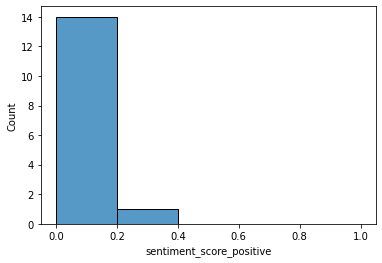

In [67]:
sns.histplot(df_sentiment, x='sentiment_score_positive',bins=[0,0.2,0.4,0.6,0.8,1]);

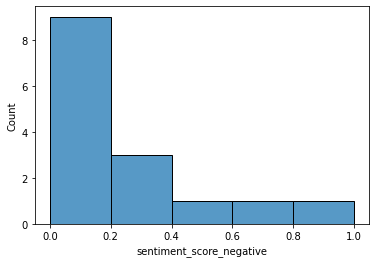

In [68]:
sns.histplot(df_sentiment, x='sentiment_score_negative',bins=[0,0.2,0.4,0.6,0.8,1]);

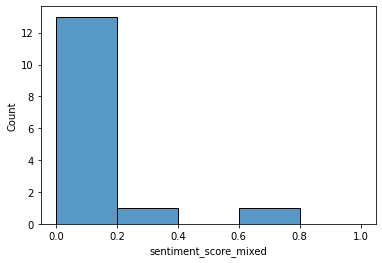

In [69]:
sns.histplot(df_sentiment, x='sentiment_score_mixed',bins=[0,0.2,0.4,0.6,0.8,1]);